# 图像特征练习
我们已经看到，通过在输入图像的像素上训练线性分类器，我们可以在图像分类任务上实现合理的表现。在本练习中，我们将展示可以通过不在原始像素上训练线性分类器，而是在根据原始像素计算的特征上训练来提高分类性能。
你为这个练习所做的所有工作都将在这个文件上完成。

In [1]:
import random
import numpy as np
from dlcv.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
与之前的练习类似，我们将从磁盘加载CIFAR-10数据。

In [2]:
from dlcv.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'dlcv/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## 提取特征
对于每个图像，我们将使用HSV颜色空间中的色调通道计算定向梯度直方图（HOG）以及颜色直方图。我们通过连接HOG和颜色直方图的特征向量来形成每个图像的最终特征向量。

粗略地说，HOG应该在忽略颜色信息的情况下捕捉图像的纹理，而颜色直方图表示输入图像的颜色，而忽略纹理。因此，我们预计两者一起使用应该比单独使用任何一个效果更好。为了自己的利益，验证这个假设是一件好事。

“hog_feature”和“color_histogram_hsv”函数都对单个图像进行操作，并返回该图像的特征向量。extract_features函数获取一组图像和一组特征函数，并评估每个图像上的每个特征函数，将结果存储在矩阵中，其中每列是单个图像的所有特征向量的级联。

In [3]:
from dlcv.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# 预处理：减去平均特征
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# 预处理：除以标准差。这样可以确保每个特征具有大致相同的比例。
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
# X_train_feats /= std_feat
# X_val_feats /= std_feat
# X_test_feats /= std_feat

# 添加一个小的 epsilon (1e-7) 来防止除以零，确保数值稳定性
X_train_feats /= (std_feat + 1e-7)
X_val_feats /= (std_feat + 1e-7)
X_test_feats /= (std_feat + 1e-7)

# 预处理：添加偏差标注
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## 基于特征训练SVM
使用任务早期开发的多类SVM代码，在上面提取的特征之上训练SVM；这应该比直接在原始像素之上训练SVM获得更好的结果。

In [4]:
# 使用验证集调整学习率和正则化强度

from dlcv.classifiers.linear_classifier import LinearSVM

learning_rates = np.arange(3e-8,5e-7,2e-8)
regularization_strengths = np.arange(1e4,2e5,2e4)

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:
# 使用验证集设置学习率和正则化强度
# 这应该与您对SVM所做的验证相同；将经过最佳训练的分类器保存在best_svm中。
# 您可能还想在颜色直方图中使用不同数量的数值条。
# 如果你小心的话，你应该能够在验证集上获得接近0.44的准确度。
################################################################################
# ***** 代码的开头（不要删除/修改此行）        *****

import numpy as np

# 遍历所有学习率
for lr in learning_rates:
    # 遍历所有正则化强度
    for reg in regularization_strengths:
        
        # 1. 创建一个新的 SVM 实例
        svm = LinearSVM()
        
        # 2. 训练模型
        #    *** 修正 ***：
        #    我们使用 X_train_feats (特征)，而不是 X_train (像素)
        svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg,
                  num_iters=1500, batch_size=200, verbose=False)
        
        # 3. 在训练集上评估
        #    *** 修正 ***：使用 X_train_feats
        y_train_pred = svm.predict(X_train_feats)
        train_accuracy = np.mean(y_train == y_train_pred)
        
        # 4. 在验证集上评估
        #    *** 修正 ***：使用 X_val_feats
        y_val_pred = svm.predict(X_val_feats)
        val_accuracy = np.mean(y_val == y_val_pred)
        
        # 5. 存储结果
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        
        # 6. 检查这是否是目前为止最好的验证准确率
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm # 保存这个最佳模型

# ***** 代码的结尾（不要删除/修改此行）        *****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved: %f' % best_val)

lr 3.000000e-08 reg 1.000000e+04 train accuracy: 0.106327 val accuracy: 0.109000
lr 3.000000e-08 reg 3.000000e+04 train accuracy: 0.103184 val accuracy: 0.100000
lr 3.000000e-08 reg 5.000000e+04 train accuracy: 0.208980 val accuracy: 0.245000
lr 3.000000e-08 reg 7.000000e+04 train accuracy: 0.364286 val accuracy: 0.388000
lr 3.000000e-08 reg 9.000000e+04 train accuracy: 0.409837 val accuracy: 0.406000
lr 3.000000e-08 reg 1.100000e+05 train accuracy: 0.410531 val accuracy: 0.412000
lr 3.000000e-08 reg 1.300000e+05 train accuracy: 0.415755 val accuracy: 0.413000
lr 3.000000e-08 reg 1.500000e+05 train accuracy: 0.414980 val accuracy: 0.424000
lr 3.000000e-08 reg 1.700000e+05 train accuracy: 0.415571 val accuracy: 0.424000
lr 3.000000e-08 reg 1.900000e+05 train accuracy: 0.413980 val accuracy: 0.427000
lr 5.000000e-08 reg 1.000000e+04 train accuracy: 0.114551 val accuracy: 0.132000
lr 5.000000e-08 reg 3.000000e+04 train accuracy: 0.239837 val accuracy: 0.256000
lr 5.000000e-08 reg 5.000000

In [5]:
# 在测试集上评估你训练过的SVM：你应该能够得到至少0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.423


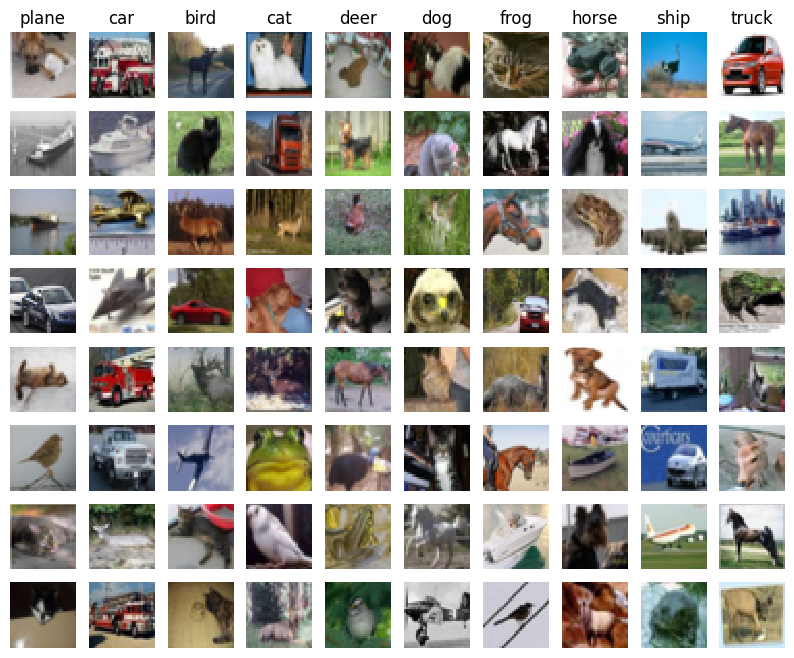

In [6]:
# 获得关于算法如何工作的直觉的一个重要方法是可视化它所犯的错误。
# 在这个可视化中，我们展示了当前系统错误分类的图像示例。
# 第一列显示了我们的系统标记为“平面”的图像，但其真正的标签不是“平面”。

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
描述您看到的错误分类结果。它们有意义吗？


$\color{blue}{\textit Your Answer:}$ 
在图表中，SVM 分类器所犯的错误非常有意义，因为它们揭示了模型完全依赖于 HOG 和颜色直方图特征。这些错误并非随机，而是系统地混淆了具有相似视觉特征的类别：例如，car（汽车）和 truck（卡车）因其相似的形状（HOG）而被混淆；deer（鹿）、dog（狗）和 horse（马）也因其相似的有机纹理和形状而相互误认；而 plane（飞机）和 ship（轮船）的混淆，很可能是因为它们共享的蓝色背景（天空和海洋）导致了相似的颜色直方图，这清晰地暴露了我们特征提取方法的局限性。



## 图像特征的神经网络
在本任务的早期，我们看到在原始像素上训练两层神经网络比在原始像素中训练线性分类器获得了更好的分类性能。在这次实验中，我们看到图像特征上的线性分类器优于原始像素上的线性分类。
为了保证完整性，我们还应该尝试在图像特征上训练神经网络。这种方法应该优于以前的所有方法：你应该能够很容易地在测试集上实现超过55%的分类准确率；我们的最佳模型实现了大约60%的分类准确率。

In [7]:
# 预处理：删除偏差尺寸
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [8]:
!pip install --upgrade pip
!pip install future

  Using cached pip-25.3-py3-none-any.whl.metadata (4.7 kB)
Using cached pip-25.3-py3-none-any.whl (1.8 MB)



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: To modify pip, please run the following command:
C:\Users\trash\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
from dlcv.classifiers.fc_net import TwoLayerNet
from dlcv.solver import Solver

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

data = {
    'X_train': X_train_feats,
    'y_train': y_train,
    'X_val': X_val_feats,
    'y_val': y_val,
    'X_test': X_test_feats,
    'y_test': y_test,
}
# net=TwoLayerNet(input_dim,hidden_dim,reg=0.001)
# print(net.params['b1'][:5])
# solver=Solver(net,data,update_rule='adam')
# solver.train()
learning_rate=np.arange(8e-5,9e-5,2e-6)
num_epochs=15
regularization_strengths = np.arange(1e-8,2e-7,3e-8)
best_net = None
best_acc=-1

################################################################################
# TODO: 在图像特征上训练两层神经网络。您可能需要像前几节中那样交叉验证各种参数。将您的最佳模型存储在best_net变量中。
################################################################################
# ***** 代码的开头（不要删除/修改此行）        *****

import numpy as np

# 遍历所有学习率
for lr in learning_rate:
    # 遍历所有正则化强度
    for reg in regularization_strengths:
        
        # 1. 实例化一个新的网络
        # 注意：reg 来自循环，input_dim, hidden_dim, num_classes 已在外部定义
        # weight_scale 使用一个合理的值，例如 1e-3 (fc_net.py 的默认值)
        net = TwoLayerNet(input_dim=input_dim,
                          hidden_dim=hidden_dim,
                          num_classes=num_classes,
                          reg=reg,
                          weight_scale=1e-3)

        # 2. 实例化一个新的 Solver
        # data 字典已在外部定义
        solver = Solver(net, data,
                        update_rule='adam',       # 如您在注释中建议的
                        optim_config={
                            'learning_rate': lr   # lr 来自循环
                        },
                        num_epochs=num_epochs,    # num_epochs 已定义为 15
                        batch_size=200,           # 一个合理的批大小
                        verbose=False)            # 避免过多打印输出
        
        # 3. 训练网络
        solver.train()
        
        # 4. 获取此模型在训练期间达到的最佳验证准确率
        # (Solver 会自动跟踪最佳验证准确率)
        current_val_acc = solver.best_val_acc
        
        # print(f'lr {lr:.2e} reg {reg:.2e} val acc: {current_val_acc:.4f}')

        # 5. 检查这是否是目前为止最好的模型
        if current_val_acc > best_acc:
            best_acc = current_val_acc
            # net 对象已被 solver 修改，包含了最佳参数
            best_net = net 

# ***** 代码的结尾（不要删除/修改此行）        *****


In [10]:
# 在测试集上运行你最好的神经网络分类器。你应该能够获得超过55%的准确率。

y_test_pred = np.argmax(best_net.loss(data['X_test']), axis=1)
test_acc = (y_test_pred == data['y_test']).mean()
print(test_acc)

0.542
